# Imports

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
import missingno as msno
import matplotlib.dates as mdates





In [51]:
!pip install gmaps
import gmaps
import gmaps.datasets
from ipywidgets.embed import embed_minimal_html
#gmaps.configure(api_key='AI*************************************')
# Third-party Jupyter widgets
#Support for third party widgets (widgets outside of the ipywidgets package)
#needs to be enabled separately. Support for these widgets will be loaded from a CDN external from Colab
from google.colab import output
output.enable_custom_widget_manager()
#Support for third party widgets will remain active for the duration of the session. To disable support:
#from google.colab import output
#output.disable_custom_widget_manager()
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter nbextension enable --py --sys-prefix gmaps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Enabling notebook extension jupyter-gmaps/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


**Data Loading**

In [52]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Accidents/Data
!ls "/content/drive/My Drive/Colab Notebooks/Data/"
Data_Folder_Name="/content/drive/My Drive/Accidents/Data/"
# only for 2020-2021

ACC_PATH_ALL =Data_Folder_Name+'dft-road-casualty-statistics-accident-1979-2021.csv'
print(ACC_PATH_ALL)
#ACC_PATH_ALL ='Data/dft-road-casualty-statistics-accident-1979-2021.csv'

#acc_df = (pd.read_csv(ACC_PATH_ALL, parse_dates=["date"])[lambda x: x['accident_year'] > 2012])

colnames=['accident_year','date','longitude','latitude', 'accident_severity','number_of_vehicles','number_of_casualties','day_of_week','time']
ACC_PATH_ALL =Data_Folder_Name+'dft-road-casualty-statistics-accident-1979-2021.csv'
print(ACC_PATH_ALL)

#ACC_PATH_ALL ='Data/dft-road-casualty-statistics-accident-1979-2021.csv'
#acc_df.head()
#colnames=['accident_year','date','longitude','latitude', 'accident_severity','number_of_vehicles','number_of_casualties','day_of_week','time']
#timeline_df=acc_df[colnames]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dft-road-casualty-statistics-accident-1979-2021.csv
dft-road-casualty-statistics-casualty-1979-2021.csv
dft-road-casualty-statistics-vehicle-1979-2021.csv
Road-Safety-Open-Dataset-Data-Guide.xlsx
dft-road-casualty-statistics-accident-2020.csv
dft-road-casualty-statistics-casualty-2020.csv
dft-road-casualty-statistics-vehicle-2020.csv
Road-Safety-Open-Dataset-Data-Guide.xlsx
/content/drive/My Drive/Accidents/Data/dft-road-casualty-statistics-accident-1979-2021.csv
/content/drive/My Drive/Accidents/Data/dft-road-casualty-statistics-accident-1979-2021.csv


In [53]:
timeline_df = (pd.read_csv(ACC_PATH_ALL, usecols=colnames)[lambda x: x['accident_year'] >= 1979])
timeline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8703911 entries, 0 to 8703910
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   accident_year         int64  
 1   longitude             float64
 2   latitude              float64
 3   accident_severity     int64  
 4   number_of_vehicles    int64  
 5   number_of_casualties  int64  
 6   date                  object 
 7   day_of_week           int64  
 8   time                  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 664.1+ MB


In [54]:
colnames=['accident_year','date','longitude','latitude', 'accident_severity','number_of_vehicles','number_of_casualties','day_of_week','time']
#timeline_df=acc_df[colnames]
d64 = dict.fromkeys(timeline_df.select_dtypes(np.int64).columns, np.int32)
timeline_df = timeline_df.astype(d64)
#converting date to datetime format
timeline_df["date"] = pd.to_datetime(timeline_df["date"], format="%d/%m/%Y")
timeline_df["hour"] = timeline_df.time.str[0:2]
#timeline_df['hour'] = timeline_df['hour'].astype('int')  # it has some old nan
#new_weekend column
timeline_df['weekend'] = np.where(timeline_df['day_of_week'].isin([1,7]), 1, 0)   # 1 is Sunday , 7 is Saturday
#new month column
timeline_df['month'] = timeline_df ['date'].apply(lambda time: time.month)
timeline_df['accident_level'] = timeline_df['accident_severity']
timeline_df['accident_level'] = timeline_df['accident_level'].replace(to_replace = 3, value = 0)
timeline_df['accident_level'] = timeline_df['accident_level'].replace(to_replace = 2, value = 1)
timeline_df['accident_level'] = timeline_df['accident_level'].replace(to_replace = 1, value = 1)
timeline_df.head()

,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,hour,weekend,month,accident_level
0,1979,NaN,NaN,3,2,1,1979-01-18,5,08:00,08,0,1.0,0
1,1979,NaN,NaN,3,1,1,1979-01-01,2,01:00,01,0,1.0,0
2,1979,NaN,NaN,3,2,3,1979-01-01,2,01:25,01,0,1.0,0
3,1979,NaN,NaN,3,2,2,1979-01-01,2,01:30,01,0,1.0,0
4,1979,NaN,NaN,2,2,1,1979-01-01,2,01:30,01,0,1.0,1


<Axes: >

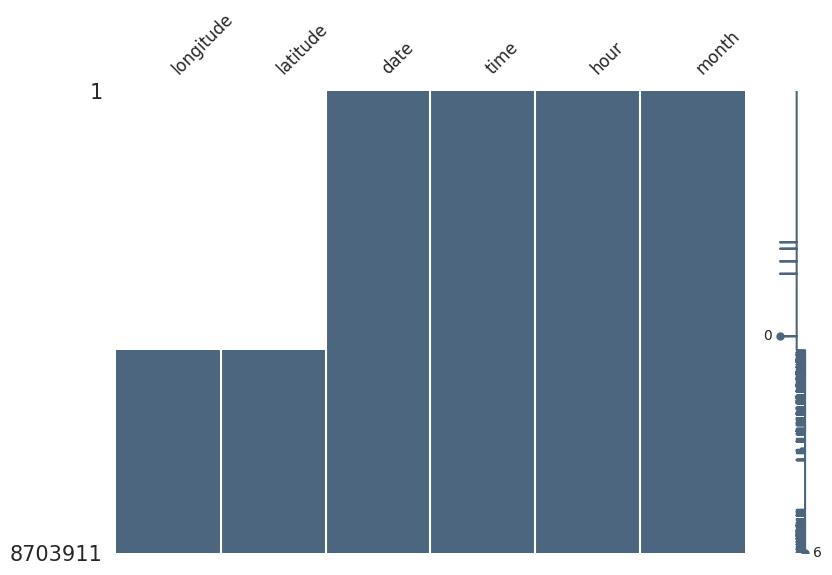

In [55]:
#dealing with other missing values:(many categories have -1 for missing value)
#visualize missing values with msno: from https://towardsdatascience.com/code-and-techniques-for-exploratory-data-analysis-a44c50953502
#import missingno as msno #moved to import section
timeline_df.replace(-1, np.nan, inplace=True)
missingdata_df = timeline_df.columns[timeline_df.isnull().any()].tolist()
msno.matrix(timeline_df[missingdata_df],figsize=(9,6),color=(0.3,0.4,0.5),fontsize=12,)

In [56]:
def groupby_accidents(df, column):
    col_agg = df.groupby(column).number_of_casualties.agg(['sum', 'count', 'mean'])
    col_agg.reset_index(inplace = True)
    col_agg.sort_values(by = column, inplace = True)
    return col_agg


def groupby_vehicles(df, column):
    col_agg = df.groupby(column).number_of_vehicles.agg(['sum', 'count', 'mean'])
    col_agg.reset_index(inplace = True)
    col_agg.sort_values(by = column, inplace = True)
    return col_agg


In [57]:
year_agg = groupby_accidents(timeline_df, 'accident_year')
year_agg2= groupby_vehicles(timeline_df, 'accident_year')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

data1 = go.Scatter(x = year_agg['accident_year'], y=year_agg['sum'], mode="lines+markers", name='Number of Casualties',
                  line= dict(color = ('rgb(255,0,0)'), width=4), showlegend = True)
##fig.add_scatter(x=df['year'], y=df['ratio'])
data2 = go.Scatter(x = year_agg['accident_year'], y=year_agg['count'], mode="lines+markers", name='Number of Accidents',
                  line= dict(color = ('rgb(255,128,0)'), width=4), showlegend = True)
data3 = go.Scatter(x = year_agg2['accident_year'], y=year_agg2['sum'], mode="lines+markers", name='Number of Vehicles in Accidents',
                  line= dict(color = ('rgb(128,128,128)'), width=4), showlegend = True)

layout = go.Layout(title='<b> Records of Road Accidents (Casualties per year) in UK between 1979 - 2021 <b>',
                   xaxis=dict(title='<b> Years <b>',titlefont=dict(size=16, color='#7f7f7f'), range=(1978.5,2021.5)),
                   yaxis=dict(title='<b> Number of Casualties <b>',titlefont=dict(size=16,color='#7f7f7f'))
                 )
#fig = make_subplots(layout = layout, layout_yaxis_range=[0,360000],specs=[[{"secondary_y": True}]])
#fig = go.Figure(data=data1, layout = layout, layout_yaxis_range=[0,360000])
#fig = go.add_Figure(data=data2, layout = layout, layout_yaxis_range=[0,360000])
#
fig = make_subplots(specs=[[{"secondary_y": True}]])
#fig.add_trace(trace1)
fig.add_trace(data3,secondary_y=True)
fig.add_trace(data1)
fig.add_trace(data2)

fig.update_layout(layout)
fig.update_layout(yaxis1 = dict(range=[0, 4.8e5]),yaxis2 = dict(range=[0, 4.8e5],showgrid=False))

fig.update_xaxes(dtick=1)

iplot(fig)

In [58]:
timeline_df=timeline_df[timeline_df.accident_year>2013]
year_agg = groupby_accidents(timeline_df, 'accident_year')
year_agg2= groupby_vehicles(timeline_df, 'accident_year')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

data1 = go.Scatter(x = year_agg['accident_year'], y=year_agg['sum'], mode="lines+markers", name='Number of Casualties',
                  line= dict(color = ('rgb(255,0,0)'), width=4), showlegend = True)
##fig.add_scatter(x=df['year'], y=df['ratio'])
data2 = go.Scatter(x = year_agg['accident_year'], y=year_agg['count'], mode="lines+markers", name='Number of Accidents',
                  line= dict(color = ('rgb(255,128,0)'), width=4), showlegend = True)
data3 = go.Scatter(x = year_agg2['accident_year'], y=year_agg2['sum'], mode="lines+markers", name='Number of Vehicles in Accidents',
                  line= dict(color = ('rgb(128,128,128)'), width=4), showlegend = True)

layout = go.Layout(title='<b> Records of Road Accidents (Casualties per year) in UK between 2014 - 2021 <b>',
                   xaxis=dict(title='<b> Years <b>',titlefont=dict(size=16, color='#7f7f7f'), range=(2013.5,2021.5)),
                   yaxis=dict(title='<b> Number of Casualties <b>',titlefont=dict(size=16,color='#7f7f7f'))
                 )
#fig = make_subplots(layout = layout, layout_yaxis_range=[0,360000],specs=[[{"secondary_y": True}]])
#fig = go.Figure(data=data1, layout = layout, layout_yaxis_range=[0,360000])
#fig = go.add_Figure(data=data2, layout = layout, layout_yaxis_range=[0,360000])
#
fig = make_subplots(specs=[[{"secondary_y": True}]])
#fig.add_trace(trace1)
fig.add_trace(data3,secondary_y=True)
fig.add_trace(data1)

fig.add_trace(data2)

fig.update_layout(layout)
fig.update_layout(yaxis1 = dict(range=[0, 2.8e5]),yaxis2 = dict(range=[0, 2.75e5],showgrid=False))

fig.update_xaxes(dtick=1)

iplot(fig)

   accident_year  month  NumberOfCasualties  NumberOfAccidents       Date
0           2014    1.0               15826              12086 2014-01-17
1           2014    2.0               14267              10780 2014-02-14
(15942.6, 19119.4)


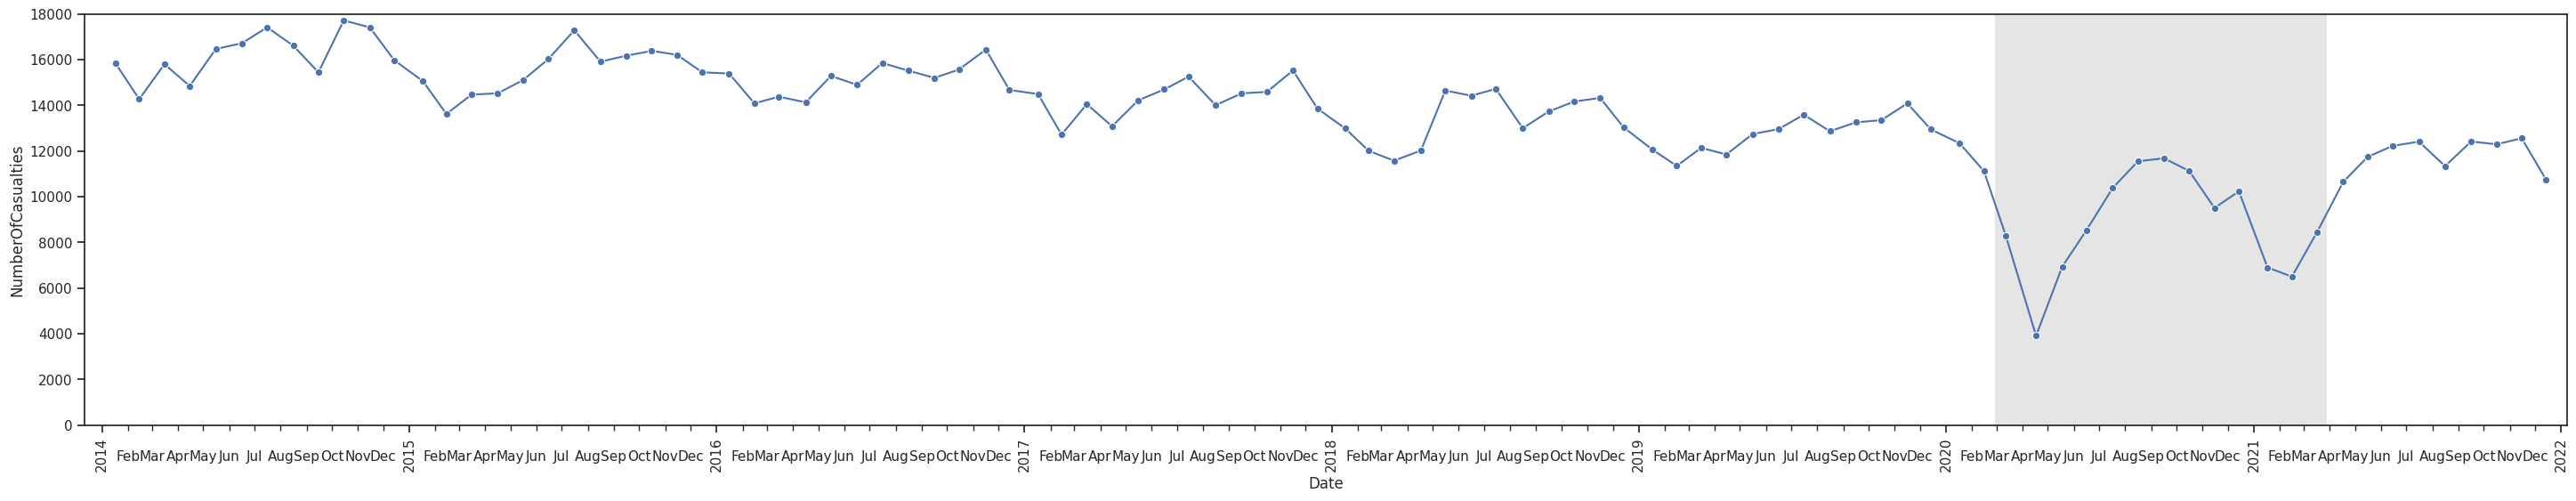

In [59]:
timeline_df=timeline_df[timeline_df.accident_year>2013]
df = timeline_df.groupby(['accident_year', 'month']).agg(NumberOfCasualties=("number_of_casualties", 'sum'),NumberOfAccidents=("number_of_casualties", 'count'),Date=('date','mean'))
df["Date"] = df["Date"].dt.round("D")
df = df.reset_index()
print(df.head(2))
plt.figure(figsize=(36,6))
sns.lineplot(x="Date",

            y='NumberOfCasualties',

            #hue="month",
            markers=True,
            marker='o',
            markersize=6,

            data=df)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title='Month')
ax = plt.gca()
plt.xticks(rotation = 90)
print(plt.xlim())
plt.xlim(16050,19000)
plt.ylim(0,18000)
ax.axvspan('2020-02-28', '2021-03-29', facecolor="gray", edgecolor="none", alpha=0.2)

ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%b'))
plt.show()

    accident_year month  NumberOfCasualties
48           2018   Jan               12985
69           2019   Oct               13347
42           2017   Jul               15254


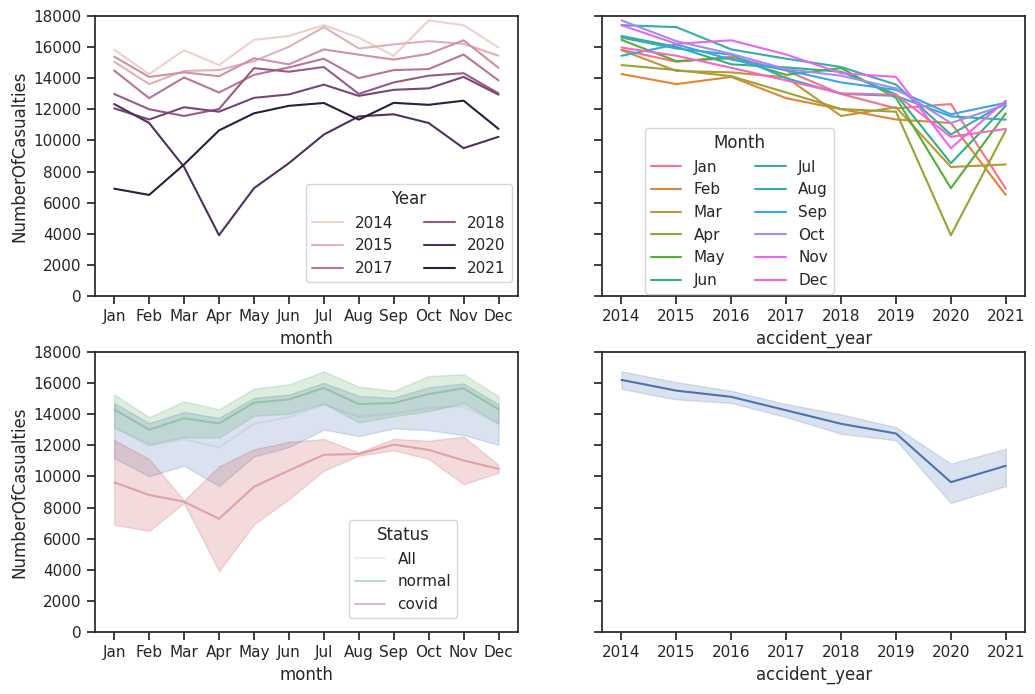

In [60]:
df = timeline_df.groupby(['accident_year', 'month']).agg(NumberOfCasualties=("number_of_casualties", 'sum'))

df = df.reset_index()
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df['month']=df["month"].apply(lambda num: month_names[int(num)-1])

print(df.sample(3))

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, sharey=True,figsize=(12,8))


sns.lineplot(x="month",y='NumberOfCasualties',hue="accident_year",data=df, ax=ax1)
ax1.set_ylim(0,18000)
ax1.legend(bbox_to_anchor=(.5, 0.4), loc='upper left', borderaxespad=0,title='Year',ncols=2)

sns.lineplot(x="accident_year",y='NumberOfCasualties',hue="month",data=df, ax=ax2)
ax2.legend(bbox_to_anchor=(.1, 0.6), loc='upper left', borderaxespad=0,title='Month',ncols=2)


sns.lineplot(x="month", y='NumberOfCasualties',data=df, ax=ax3, alpha=0.1, label='All')
sns.lineplot(x="accident_year", y='NumberOfCasualties',data=df, ax=ax4)


df1=df[df.accident_year<2020]
sns.lineplot(x="month", y='NumberOfCasualties',data=df1, ax=ax3, color='g', alpha=0.4, label='normal')
df2=df[df.accident_year>2019]
sns.lineplot(x="month", y='NumberOfCasualties',data=df2, ax=ax3, color='r', alpha=0.4, label='covid')
ax3.legend(bbox_to_anchor=(.6, 0.4), loc='upper left', borderaxespad=0,title='Status',ncols=1)


plt.show()

**Adding Covid**

To investigate the effect of covid on fatality of the accidents in Uk, it is good to look at the timeline of covid major events first.
sources:
https://www.google.com/search?client=firefox-b-1-e&q=timeline+of+covid+in+uk

https://www.youtube.com/watch?v=T9jgle7Hekc

https://dadoverflow.com/2021/08/17/making-timelines-with-python/

<ipython-input-61-317c4657f1fc>:30: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



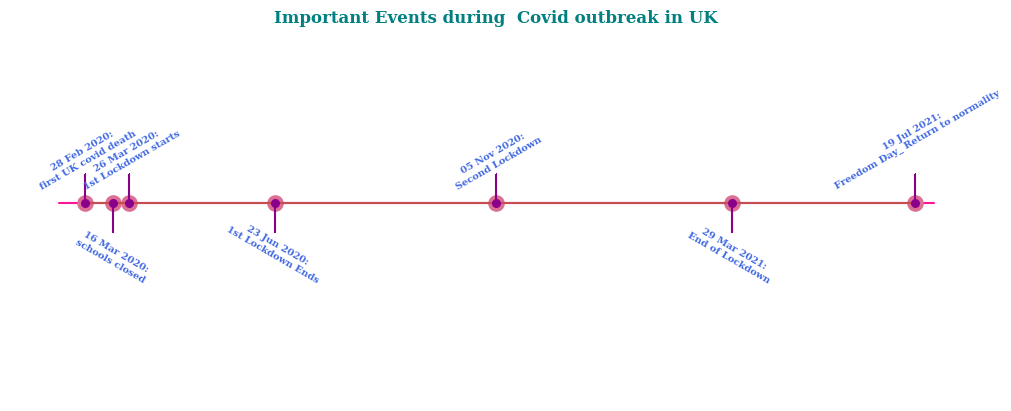

In [61]:
from datetime import date
import numpy as np
dates=[date(2020, 2, 28),date(2020, 3, 16),date(2020, 3, 26),date(2020, 6, 23),date(2020, 11, 5),date(2021, 3, 29),date(2021,7,19)]
Covid_label=['first UK covid death','schools closed','1st Lockdown starts','1st Lockdown Ends','Second Lockdown','End of Lockdown','Freedom Day_ Return to normality']
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (Covid_label, dates)]
labels
min_date = date(np.min(dates).year , np.min(dates).month-1, np.min(dates).day-15)
max_date = date(np.max(dates).year , np.max(dates).month+1, np.max(dates).day+10)

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
_ = ax.set_ylim(-2, 1.75)
_ = ax.set_xlim(min_date, max_date)
_ = ax.axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)

_ = ax.scatter(dates, np.zeros(len(dates)), s=120, c='palevioletred', zorder=2)
_ = ax.scatter(dates, np.zeros(len(dates)), s=30, c='darkmagenta', zorder=3)

label_offsets = np.zeros(len(dates))
label_offsets[::2] = 0.15
label_offsets[1::2] = -0.8
for i, (l, d) in enumerate(zip(labels, dates)):
  if i%2==1:
    _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=7, rotation=-30)
  else:
    _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=7, rotation=30)

stems = np.zeros(len(dates))
stems[::2] = 0.3
stems[1::2] = -0.3
markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
_ = plt.setp(markerline, marker=',', color='darkmagenta')
_ = plt.setp(stemline, color='darkmagenta')

# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)

# hide tick labels
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.set_title('Important Events during  Covid outbreak in UK', fontweight="bold", fontfamily='serif', fontsize=12,
                 color='teal')

In [62]:
## UK Lockdown 23 march 2020 till 29 march 2021
timeline_df['covid']=((timeline_df['date']> '2020-02-28')&(timeline_df['date']< '2021-03-29')).astype(int)
#data["Time"].isin(['07','08','09','15','16','17','18']).astype(int)
date_range = str(timeline_df['date'].dt.date.min()) + ' to ' +str(timeline_df['date'].dt.date.max())
timeline_df[['date','covid']].sample(10).T

,7944060,8611949,8169698,8389367,7950145,8009843,8358464,8594035,8444684,8150401
date,2015-01-08 00:00:00,2021-06-15 00:00:00,2017-05-14 00:00:00,2018-01-26 00:00:00,2015-07-22 00:00:00,2016-09-12 00:00:00,2018-02-07 00:00:00,2020-01-14 00:00:00,2019-03-20 00:00:00,2017-05-10 00:00:00
covid,0,0,0,0,0,0,0,0,0,0


In [63]:
d64 = dict.fromkeys(timeline_df.select_dtypes(np.int64).columns, np.int32)
timeline_df = timeline_df.astype(d64)
timeline_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 985438 entries, 7718473 to 8703910
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   accident_year         985438 non-null  int32         
 1   longitude             985261 non-null  float64       
 2   latitude              985261 non-null  float64       
 3   accident_severity     985438 non-null  int32         
 4   number_of_vehicles    985438 non-null  int32         
 5   number_of_casualties  985438 non-null  int32         
 6   date                  985438 non-null  datetime64[ns]
 7   day_of_week           985438 non-null  int32         
 8   time                  985438 non-null  object        
 9   hour                  985438 non-null  object        
 10  weekend               985438 non-null  int32         
 11  month                 985438 non-null  float64       
 12  accident_level        985438 non-null  int32       

Text(0, 0.5, '% of Accidents ')

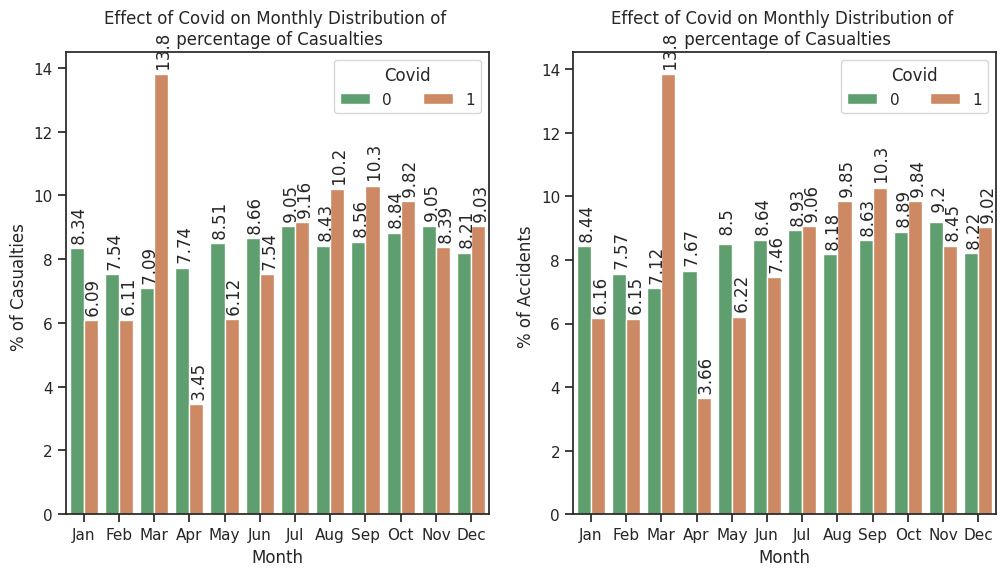

In [64]:
#timeline_df['Month']=timeline_df['date'].dt.strftime('%b')
df = timeline_df.groupby(['covid', 'month']).agg(
        NumberOfCasualties= ("number_of_casualties", 'sum'),
        NumberOfAccidents = ("number_of_casualties", 'count'),
    )
df = df.reset_index()

df['%C'] = 100 * df['NumberOfCasualties'] / df.groupby('covid')['NumberOfCasualties'].transform('sum')
df['%A'] = 100 * df['NumberOfAccidents'] / df.groupby('covid')['NumberOfAccidents'].transform('sum')


#changing the name of month from 1 to Jan
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df['Month']=df["month"].apply(lambda num: month_names[int(num)-1])

fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2, sharey=False,figsize=(12,6))
sns.barplot(x="Month",y='%C',hue="covid",data=df,ax=ax1,palette=['C2','C1'])
for p in ax1.patches:
        patch_height = p.get_height()
        if np.isnan(patch_height):
            patch_height = 0
        ax1.annotate('{: 5.3}'.format(float(patch_height)), (p.get_x()+0.05, patch_height+0.1),rotation=90)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_title('Effect of Covid on Monthly Distribution of \n percentage of Casualties')
ax1.legend(title='Covid',ncols=2)
ax1.set_ylabel('% of Casualties ')

sns.barplot(x="Month",y='%A',hue="covid",palette=['C2','C1'],data=df,ax=ax2)
for p in ax2.patches:
        patch_height = p.get_height()
        if np.isnan(patch_height):
            patch_height = 0
        ax2.annotate('{: 5.3}'.format(float(patch_height)), (p.get_x()+0.05, patch_height+0.1),rotation=90)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax2.set_title('Effect of Covid on Monthly Distribution of \n percentage of Casualties')
ax2.legend(title='Covid',ncols=2)
ax2.set_ylabel('% of Accidents ')

#plt.show()


#https://stackoverflow.com/questions/34615854/countplot-with-normalized-y-axis-per-group

In [65]:
print(timeline_df[['covid']].value_counts())

df1 = timeline_df.groupby(['covid', 'accident_severity']).agg({"number_of_casualties": 'sum'})
df1['percent_of_casualties'] = 100 * df1['number_of_casualties'] / df1.groupby('covid')['number_of_casualties'].transform('sum')
df1 = df1.reset_index()
print(df1.groupby('covid').agg({'number_of_casualties':'sum'}))  # number of casualties for normal is 10.39 X of covid

df2 = timeline_df.groupby(['covid', 'accident_severity']).agg(number_of_accidents=("number_of_casualties", 'count'))
df2['percent_of_accidents'] = 100 * df2['number_of_accidents'] / df2.groupby('covid')['number_of_accidents'].transform('sum')
df2 = df2.reset_index()
print(df2.groupby('covid').agg({'number_of_accidents':'sum'}))

df=df1.merge(df2, on = ['covid','accident_severity'], how = 'left')
severity_names=['Fatal','Severe','Minor']
df['severity']=df.accident_severity.apply(lambda x:severity_names[int(x)-1])
df

covid
0        895365
1         90073
dtype: int64
       number_of_casualties
covid                      
0                   1177309
1                    113282
       number_of_accidents
covid                     
0                   895365
1                    90073


,covid,accident_severity,number_of_casualties,percent_of_casualties,number_of_accidents,percent_of_accidents,severity
0,0,1,19686,1.672118,11490,1.283276,Fatal
1,0,2,210457,17.876106,151739,16.947167,Severe
2,0,3,947166,80.451776,732136,81.769558,Minor
3,1,1,2096,1.850250,1349,1.497674,Fatal
4,1,2,24231,21.389983,18311,20.329066,Severe
5,1,3,86955,76.759768,70413,78.173259,Minor


**Seriousness of Accidents are affected by covid**

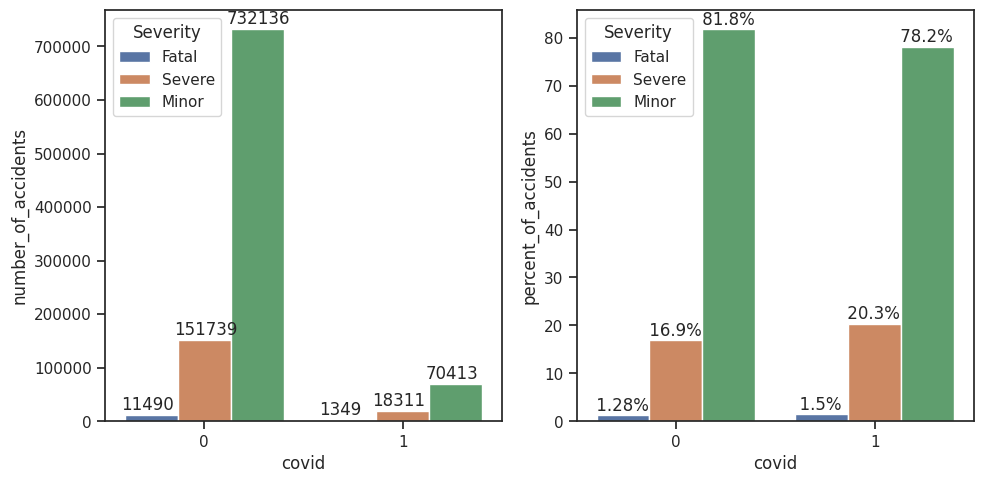

In [66]:

sns.set(style="ticks")
exercise = sns.load_dataset("exercise")

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

sns.barplot(x='covid', y='number_of_accidents', hue='severity', data=df, ax=ax1)
for p in ax1.patches:
        patch_height = p.get_height()
        if np.isnan(patch_height):
            patch_height = 0
        ax1.annotate('{}'.format(int(patch_height)), (p.get_x()-0.02, patch_height+10000),rotation=0)
sns.barplot(x='covid', y='percent_of_accidents', hue='severity', data=df, ax=ax2)
for p in ax2.patches:
        patch_height = p.get_height()
        if np.isnan(patch_height):
            patch_height = 0
        ax2.annotate('{: 5.3}'.format(float(patch_height))+'%', (p.get_x()-0.03, patch_height+1),rotation=0)
ax2.legend(title='Severity',bbox_to_anchor=(.02, 0.98), loc='upper left', borderaxespad=0,)
ax1.legend(title='Severity',bbox_to_anchor=(.02, 0.98), loc='upper left', borderaxespad=0,)
fig.tight_layout()

In [67]:
#fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2, sharey=False,figsize=(12,6))

#sns.catplot(x='covid', y='number_of_accidents', hue='accident_severity', data=df, kind='bar', ax=ax1)

#sns.catplot(x='covid', y='percent_of_accidents', hue='accident_severity', data=df, kind='bar', ax=ax2) # these are figure level not compatible with subplots


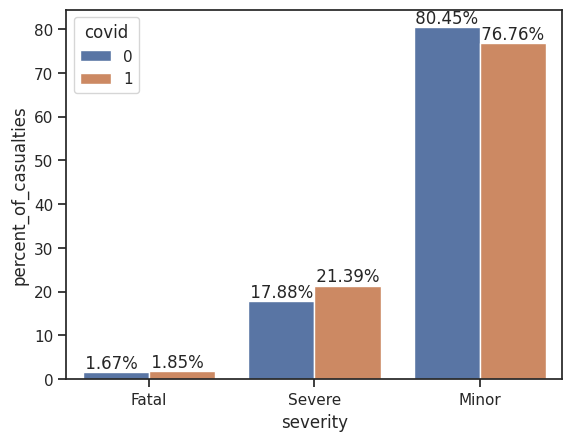

In [68]:
ax=sns.barplot(x="severity",

            y='percent_of_casualties',

            hue="covid",

            data=df)
for p in ax.patches:
        patch_height = p.get_height()
        if np.isnan(patch_height):
            patch_height = 0
        ax.annotate('{: 3.2f}'.format(float(patch_height))+'%', (p.get_x()-0.02, patch_height+0.9))
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Is this Change statistically significant?
Lets perform a simulation assuming the probability distributions for various severity during covid is the same as those during normal days.

In [69]:
timeline_df[['covid']].value_counts()
#df

covid
0        895365
1         90073
dtype: int64

In [70]:
import random
import numpy as np
import matplotlib.pyplot as plt
# simiulation was for data obtained after 2016 we need to update the numbers to after 2014
Ftl=[]
Svr=[]
Mnr=[]
for i in range(1000):  #to run faster i lowered the number from 10000
    v1=0
    v2=0
    v3=0
    for j in range(111542):
      ran=random.randint(1,798284)
      if ran<13945: v1+=1
      elif ran<(13945+153569): v2+=1
      else: v3+=1
    Ftl.append(v1)
    Svr.append(v2)
    Mnr.append(v3)

1948.417 21452.516 88141.067
197.61786702117803 3712.4469745215188 18.785988486170982


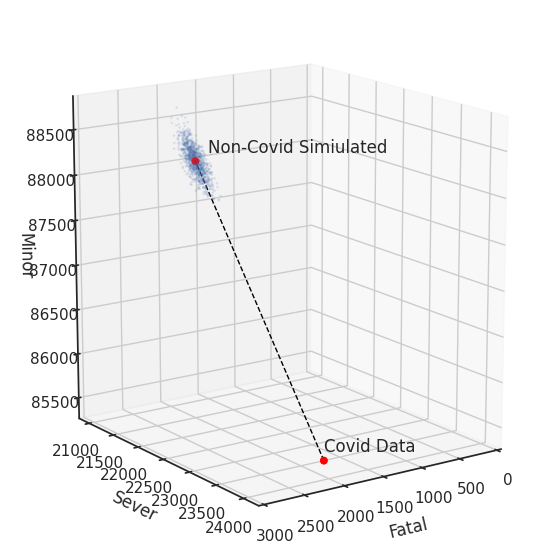

In [71]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(Ftl, Svr, Mnr, marker='o',alpha=0.1,s=1)
ax.set_xlabel('Fatal')
ax.set_ylabel('Sever')
ax.set_zlabel('Minor')
ax.set_xlim3d(0, 3000)
X=np.mean(np.array(Ftl))
Y=np.mean(np.array(Svr))
Z=np.mean(np.array(Mnr))
std_sim=np.sqrt(np.std(np.array(Ftl))**2+np.std(np.array(Svr))**2+np.std(np.array(Mnr))**2)
print(X,Y,Z)
distance=np.sqrt((2100-X)**2+(24049-Y)**2+(85492-Z)**2)
print(std_sim,distance,distance/std_sim)

x1, y2, z3 = [2100, X], [24049, Y], [85492, Z]
ax.plot(x1, y2, z3, color='black', linestyle='dashed', linewidth=1)
ax.scatter(x1, y2, z3, c='red', s=20)
ax.scatter(x1, y2, z3, c='red', s=20)
ax.scatter(X, Y, Z, c='red', s=20)

#ax.xaxis.set_tick
ax.azim = 55
ax.elev = 15

ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
ax.text3D(2110,24069,85592,'Covid Data')
ax.text3D(1847,21558,88235,'Non-Covid Simiulated')
plt.show()

We are 20 sigma away from simiulated non covid samples. It is definetly statistically significant

**Effect of Covid on week of the day distributions of accidents**



In [72]:
d=timeline_df["day_of_week"].loc[timeline_df["accident_severity"]==1].value_counts().sort_index()
print('number of fatal accidents: ',len(timeline_df.loc[timeline_df["accident_severity"]==1]),d.sum())
print(' Their distribution in days of the week')
d

number of fatal accidents:  12839 12839
 Their distribution in days of the week


1    1990
2    1705
3    1644
4    1687
5    1786
6    1915
7    2112
Name: day_of_week, dtype: int64

In [73]:
WD=timeline_df["day_of_week"].value_counts().sort_index() #Weekday Distribution
WPD=WD*100/WD.sum()   ##Weekday Percentage Distribution
WDN= timeline_df[timeline_df.covid==0]["day_of_week"].value_counts().sort_index()#Weekday Distribution Normal
WDC= timeline_df[timeline_df.covid==1]["day_of_week"].value_counts().sort_index()#Weekday Distribution Covid
WPDC= timeline_df[timeline_df.covid==1]["day_of_week"].value_counts().sort_index()*100/WDC.sum()  #Weekday Percentage Distribution Covid
WPDN= WDN*100/WDN.sum() #Weekday Percentage Distribution Normal
#print(pd.DataFrame(WDC).join(WDN))
WD=pd.concat({'WD':WD,'WDC':WDC,'WDN':WDN,'WPD':WPD,'WPDC':WPDC,'WPDN':WPDN},axis=1)
print(WDC.sum())
WD['Days'] = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
WD



90073


,WD,WDC,WDN,WPD,WPDC,WPDN,Days
1,109743,10482,99261,11.136469,11.637228,11.086093,Sun
2,139467,12550,126917,14.152793,13.933143,14.174890,Mon
3,146756,12797,133959,14.892464,14.207365,14.961384,Tue
4,148407,13157,135250,15.060004,14.607041,15.105571,Wed
5,149815,13615,136200,15.202884,15.115517,15.211673,Thu
6,161149,14843,146306,16.353033,16.478856,16.340375,Fri
7,130101,12629,117472,13.202353,14.020850,13.120013,Sat


In [74]:
# Make a quick df to test groupby
dfx=pd.DataFrame(columns=["A","B","C"],data=np.random.randint(0,5,size=(10,3)))


In [87]:
#test=timeline_df.groupby(['date','accident_severity']).number_of_casualties.agg({'number_of_casualties':'sum','month':'count'})
#temp = pd.DataFrame(timeline_df.groupby(['date','accident_severity'])['number_of_casualties'].agg(daily_cas='sum')).rename()['daily_cas']

temp=timeline_df.groupby(['date','accident_severity']).agg(
    daily_cas = pd.NamedAgg(column='number_of_casualties', aggfunc='sum'),
    daily_acc = ('number_of_casualties', 'count'),
    week_day = ('day_of_week','min'),
).reset_index()
week_names=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
temp['weekday']=temp['week_day'].apply(lambda num: week_names[int(num)-1])
temp['weekend'] = np.where(temp['week_day'].isin([1,7]), 1, 0)
temp['covid']=((temp['date']> '2020-02-28')&(temp['date']< '2021-03-29')).astype(int)

#temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
#test=timeline_df.groupby(['date','accident_severity']).agg((daily_cas:={'number_of_casualties':'sum'},daily_acc:={'number_of_casualties':'count'}))
#test.reset_index()
temp

,date,accident_severity,daily_cas,daily_acc,week_day,weekday,weekend,covid
0,2014-01-01,1,13,6,4,Wed,0,0
1,2014-01-01,2,69,49,4,Wed,0,0
2,2014-01-01,3,284,212,4,Wed,0,0
3,2014-01-02,1,8,4,5,Thu,0,0
4,2014-01-02,2,75,47,5,Thu,0,0
...,...,...,...,...,...,...,...,...
8698,2021-12-30,2,65,45,5,Thu,0,0
8699,2021-12-30,3,226,170,5,Thu,0,0
8700,2021-12-31,1,4,3,6,Fri,0,0
8701,2021-12-31,2,69,54,6,Fri,0,0


Saturday Valentines are deadly, watch out for 2016:
Sat 2015-02-14 is by far the deadliest uk day in past decade with 59 death on 9 recorded fatal accidents we can call it the `**BLOODY VALENTINE**`

           date  accident_severity  daily_cas  daily_acc  week_day weekday  \
389  2014-05-13                  1         33          6         3     Tue   
1218 2015-02-14                  1         59          9         7     Sat   
1891 2015-09-27                  1         31         10         1     Sun   
5753 2019-04-14                  1         33          7         1     Sun   

      weekend  covid  
389         0      0  
1218        1      0  
1891        1      0  
5753        1      0  
           date  accident_severity  daily_cas  daily_acc  week_day weekday  \
1218 2015-02-14                  1         59          9         7     Sat   
1219 2015-02-14                  2         61         37         7     Sat   
1220 2015-02-14                  3        368        271         7     Sat   

      weekend  covid  
1218        1      0  
1219        1      0  
1220        1      0  


<Figure size 400x1200 with 0 Axes>

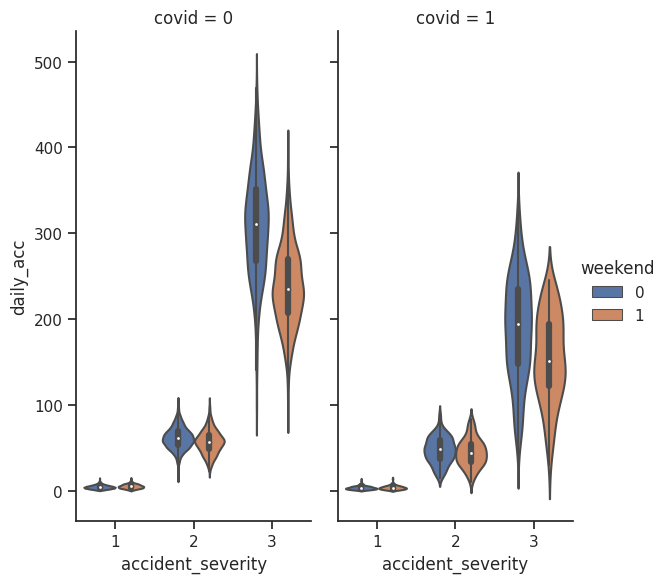

In [103]:
#sns.jointplot(data=temp, x="daily_acc", y="daily_cas", hue="weekend", alpha=0.5,marker='o',kind="hist")
plt.figure(figsize=(4,12))
sns.catplot(data=temp, x="accident_severity", y="daily_acc", hue="weekend",col='covid', alpha=0.5,kind="violin",figsize=(4,12),height=6, aspect=.5)

#plt.xlim(-1,40)
#plt.ylim(-1,60)
print(temp[(temp.accident_severity==1)&(temp.daily_cas>30)])
print(temp[temp.date=='2015-02-14'])

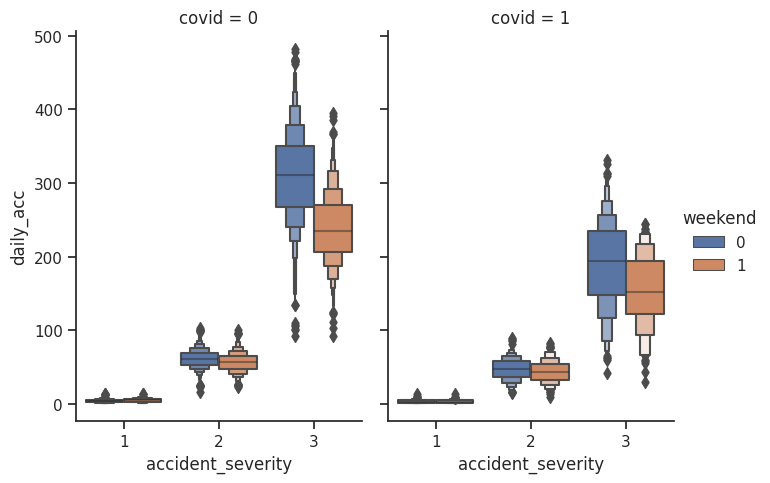

In [106]:
sns.catplot(data=temp, x="accident_severity", y="daily_acc", hue="weekend",col='covid',kind='boxen',aspect=.7,)


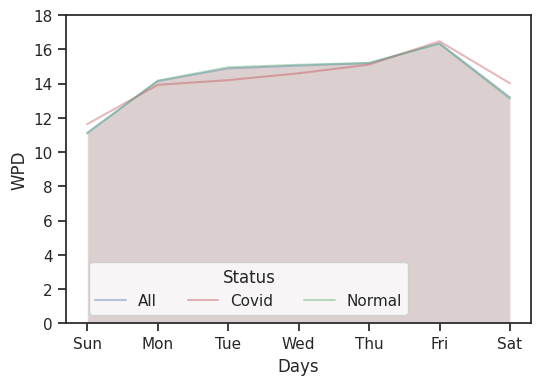

In [126]:
fig, (ax) = plt.subplots(nrows=1,ncols=1, sharey=True,figsize=(6,4))
sns.lineplot(x="Days", y='WPD',data=WD, ax=ax, color='b', alpha=0.4, label='All',markers=True,)
plt.fill_between(WD.Days.values, WD.WPD.values,alpha=0.2)
sns.lineplot(x="Days", y='WPDC',data=WD, ax=ax, color='r', alpha=0.4, label='Covid', markers=True, dashes=False)
#plt.fill_between(WD.Days.values, WD.WPDC.values,alpha=0.2)

sns.lineplot(x="Days", y='WPDN',data=WD, ax=ax, color='g', alpha=0.4, label='Normal',markers=True)
plt.fill_between(WD.Days.values, WD.WPDN.values,alpha=0.2)

plt.ylim(0,18)
ax.legend(bbox_to_anchor=(.05, 0.2), loc='upper left', borderaxespad=0,title='Status',ncols=3)


No. of rows: 985438
No. of cols: 14


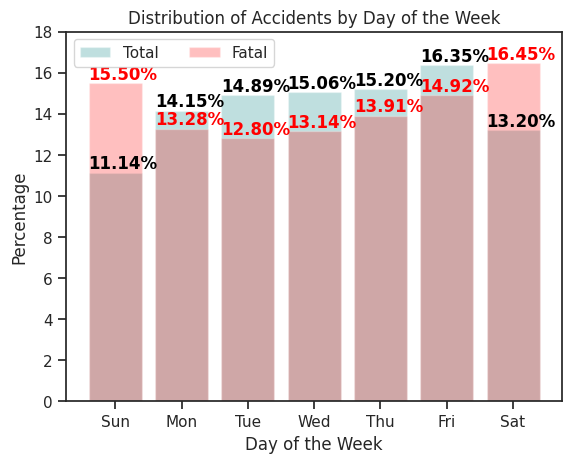

In [78]:
print("No. of rows: {}".format(timeline_df.shape[0]))
print("No. of cols: {}".format(timeline_df.shape[1]))
### Percentage of number of fatal accidents in each day of week
Day_of_Week_F = timeline_df["day_of_week"].loc[timeline_df["accident_severity"]==1].value_counts().sort_index()/len(timeline_df.loc[timeline_df["accident_severity"]==1])*100
### Percentage of number of accidents in each day of week
Day_of_Week_T = timeline_df["day_of_week"].value_counts().sort_index()/len(timeline_df)*100
Day_of_Week_T.index = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
plt.bar(Day_of_Week_T.index, Day_of_Week_T.values, alpha=0.25, color="teal",label='Total')
plt.bar(Day_of_Week_T.index, Day_of_Week_F.values, alpha=0.25, color="red",label='Fatal')
plt.title("Distribution of Accidents by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Percentage")
plt.ylim(0,18)
for i, val in enumerate(Day_of_Week_T.values):
    plt.text(i-0.4, val+0.2,  str( "{:.{}f}".format( val, 2 ))+'%', color='black', fontweight='bold')
for i, val in enumerate(Day_of_Week_F.values):
    plt.text(i-0.4, val+0.2,  str( "{:.{}f}".format( val, 2 ))+'%', color='red', fontweight='bold')
plt.legend(ncols=2)

Fatal Accidents Are More likely to happen during a Weekend day. (31.95% Fatal accidents vs 24.34% of accidents)  . Easy to do comparison for minor or non-fatal accidents distribution as well.

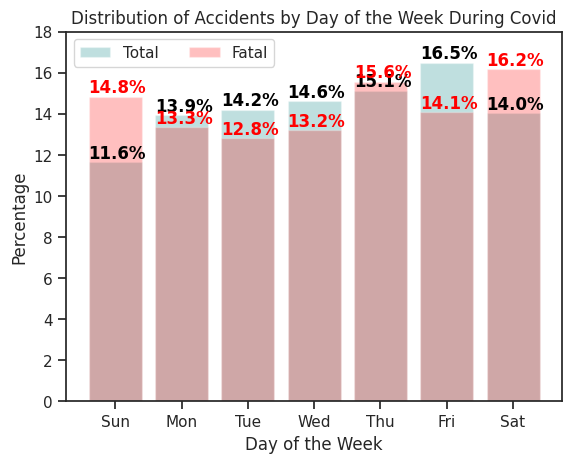

In [121]:
covid_df=timeline_df[timeline_df.covid==1]
normal_df=timeline_df[timeline_df.covid==0]
#print(covid_df.info(),normal_df.info())

Day_of_Week_F = covid_df["day_of_week"].loc[covid_df["accident_severity"]==1].value_counts().sort_index()/len(covid_df.loc[covid_df["accident_severity"]==1])*100
Day_of_Week_D = covid_df["day_of_week"].value_counts().sort_index()/len(covid_df)*100
Day_of_Week_D.index = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
plt.bar(Day_of_Week_D.index, Day_of_Week_D.values, alpha=0.25, color="teal",label='Total')
plt.bar(Day_of_Week_D.index, Day_of_Week_F.values, alpha=0.25, color="red",label='Fatal')
plt.title("Distribution of Accidents by Day of the Week During Covid")
plt.xlabel("Day of the Week")
plt.ylabel("Percentage")
plt.ylim(0,18)
for i, val in enumerate(Day_of_Week_D.values):
    plt.text(i-0.4, val+0.2,  str( "{:.{}f}".format( val, 1 ))+'%', color='black', fontweight='bold')
for i, val in enumerate(Day_of_Week_F.values):
    plt.text(i-0.4, val+0.2,  str( "{:.{}f}".format( val, 1 ))+'%', color='red', fontweight='bold')
plt.legend(ncols=2)

**During covid, though bigger ratio of accidents happen on weekend yet they are less fatal.**

In [80]:
#sns.pairplot(data=timeline_df, hue="accident_severity")

    covid  day_of_week  NumberOfAccidents    percent
0       0            1              99261  11.086093
1       0            2             126917  14.174890
2       0            3             133959  14.961384
3       0            4             135250  15.105571
4       0            5             136200  15.211673
5       0            6             146306  16.340375
6       0            7             117472  13.120013
7       1            1              10482  11.637228
8       1            2              12550  13.933143
9       1            3              12797  14.207365
10      1            4              13157  14.607041
11      1            5              13615  15.115517
12      1            6              14843  16.478856
13      1            7              12629  14.020850


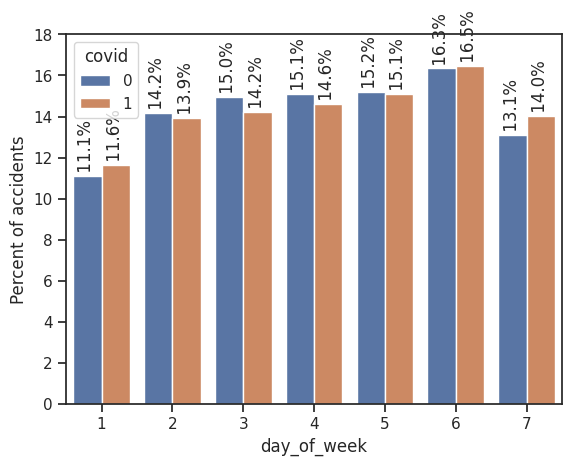

In [127]:
df = timeline_df.groupby(['covid', 'day_of_week']).agg(NumberOfAccidents=("number_of_casualties", 'count'))
df['percent'] = 100 * df['NumberOfAccidents'] / df.groupby('covid')['NumberOfAccidents'].transform('sum')
df = df.reset_index()
print(df)
ax=sns.barplot(x="day_of_week",

            y='percent',

            hue="covid",

            data=df)
for p in ax.patches:
        patch_height = p.get_height()
        if np.isnan(patch_height):
            patch_height = 0
        ax.annotate('{: 3.1f}'.format(float(patch_height))+'%', (p.get_x()+0.06, patch_height+0.1),rotation=90)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim(0,18)
plt.ylabel('Percent of accidents')
plt.show()

**Does Covid Affect the hourly distributions of accidents/casualties?**

In [128]:
timeline_df.head(1)
#covid_df=timeline_df[timeline_df.covid==1]
#normal_df=timeline_df[timeline_df.covid==0]

,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,hour,weekend,month,accident_level,covid
7718473,2014,-0.206443,51.496345,3,2,1,2014-01-09,5,13:21,13,0,1.0,0,0


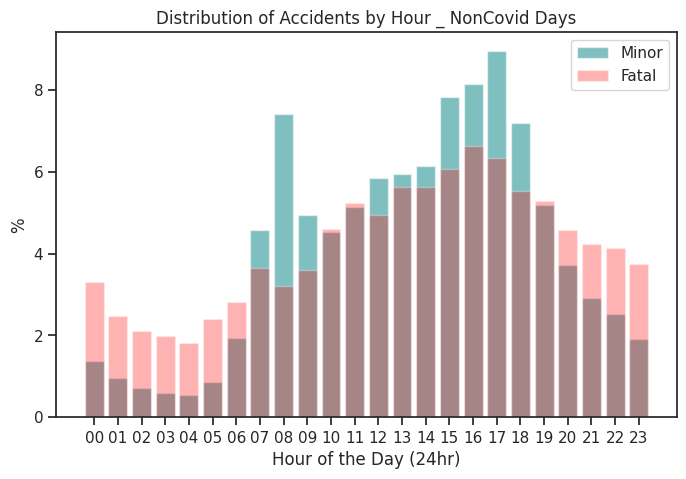

In [130]:
Acc_By_Hour = normal_df["hour"].loc[normal_df["accident_severity"]==3].value_counts().sort_index()  # minor accidents
Acc_By_Hour = (Acc_By_Hour/Acc_By_Hour.sum())*100
Acc_By_Hour_By_Fatal = normal_df["hour"].loc[normal_df["accident_severity"]==1].value_counts().sort_index()    # Fatal Accidents
Acc_By_Hour_By_Fatal = (Acc_By_Hour_By_Fatal/Acc_By_Hour_By_Fatal.sum())*100
plt.figure(1, figsize=(8,5))
plt.bar(Acc_By_Hour.index, Acc_By_Hour.values, alpha=0.5, color="teal", label='Minor')
plt.bar(Acc_By_Hour.index, Acc_By_Hour_By_Fatal.values, alpha=0.3, color="red", label='Fatal')
plt.title("Distribution of Accidents by Hour _ NonCovid Days")
plt.ylabel("%")
plt.xlabel("Hour of the Day (24hr)")
plt.legend()

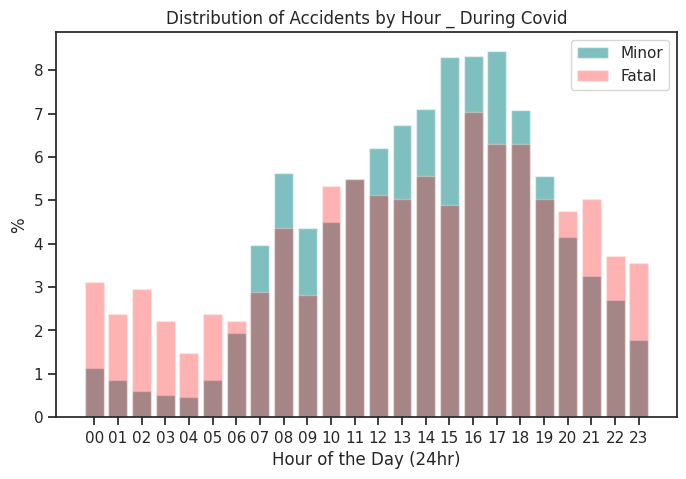

In [133]:
Acc_By_Hour = covid_df["hour"].loc[covid_df["accident_severity"]==3].value_counts().sort_index()  # minor accidents
Acc_By_Hour = (Acc_By_Hour/Acc_By_Hour.sum())*100
Acc_By_Hour_By_Fatal = covid_df["hour"].loc[covid_df["accident_severity"]==1].value_counts().sort_index()    # Fatal Accidents
Acc_By_Hour_By_Fatal = (Acc_By_Hour_By_Fatal/Acc_By_Hour_By_Fatal.sum())*100
plt.figure(1, figsize=(8,5))
plt.bar(Acc_By_Hour.index, Acc_By_Hour.values, alpha=0.5, color="teal", label='Minor')
plt.bar(Acc_By_Hour.index, Acc_By_Hour_By_Fatal.values, alpha=0.3, color="red", label='Fatal')
plt.title("Distribution of Accidents by Hour _ During Covid")
plt.ylabel("%")
plt.xlabel("Hour of the Day (24hr)")
plt.legend()

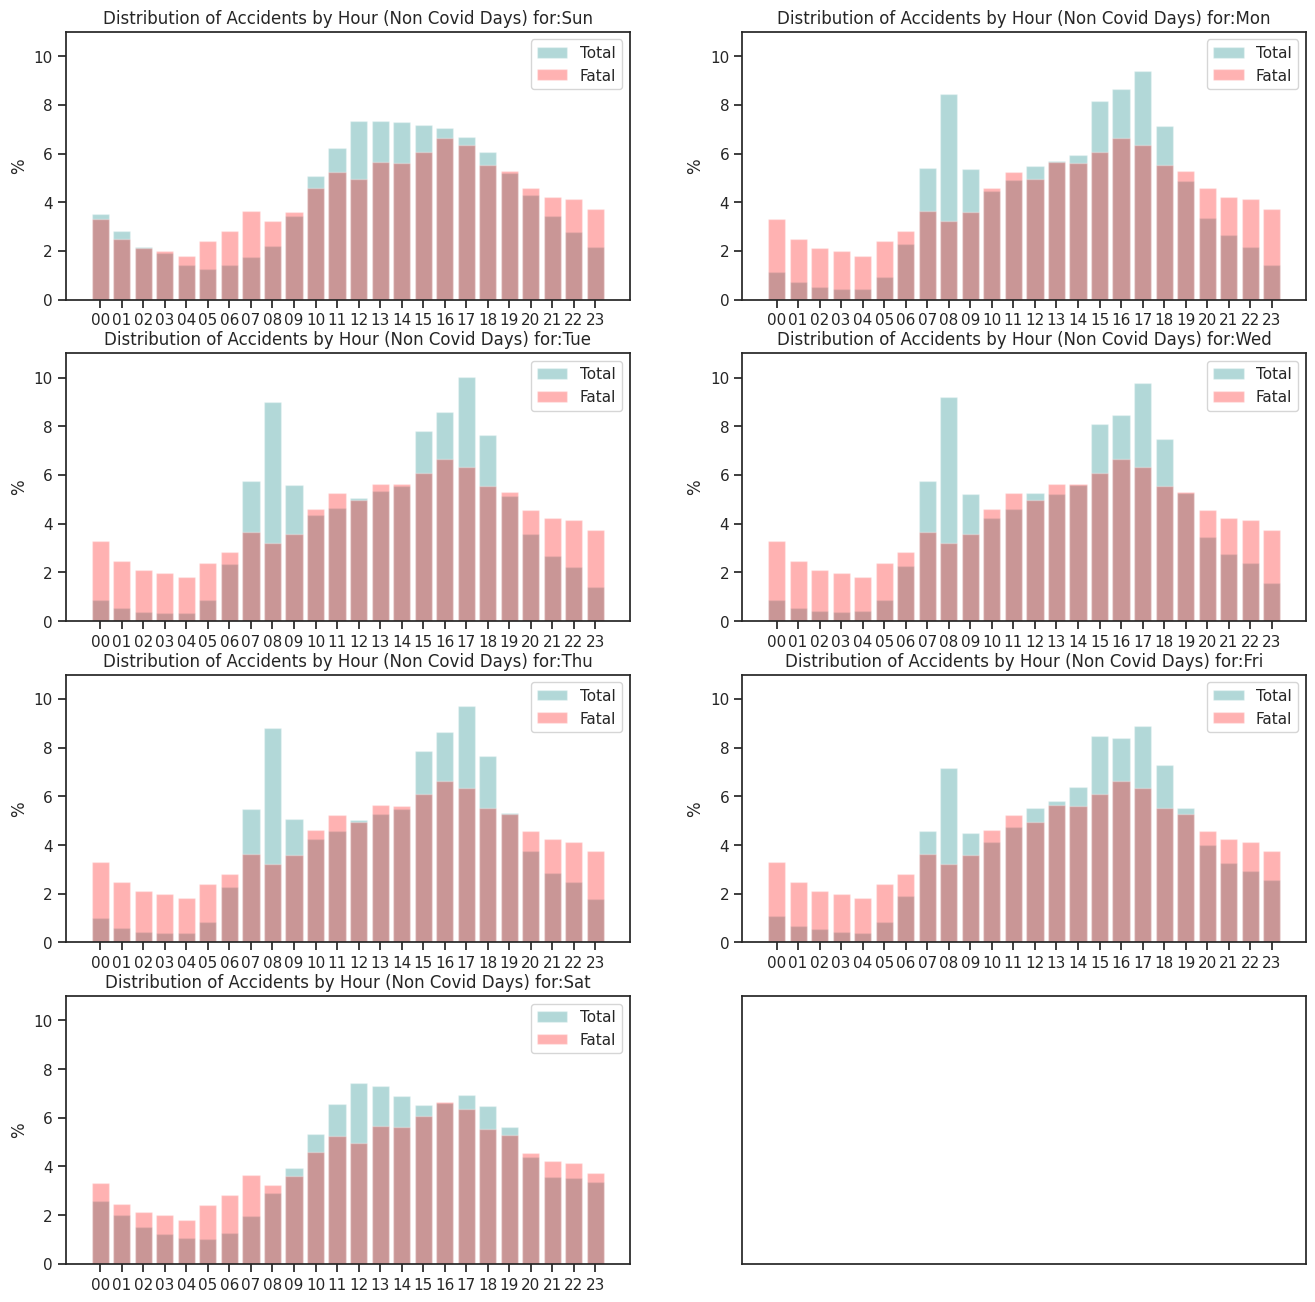

In [132]:
Day_Of_Week_Dict = {1:"Sun", 2:"Mon", 3:"Tue", 4:"Wed", 5:"Thu", 6:"Fri", 7:"Sat"}

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16,16))
count = 0

for i, col in enumerate(normal_df["day_of_week"].sort_values().unique()):
    Acc_By_Hour_By_Day = normal_df["hour"].loc[normal_df["day_of_week"]==col].value_counts().sort_index()
    Acc_By_Hour_By_Day = (Acc_By_Hour_By_Day/Acc_By_Hour_By_Day.sum())*100

    Acc_By_Hour_Fatal = normal_df["hour"].loc[(normal_df["day_of_week"]==col) & (normal_df["accident_severity"]==1)].value_counts().sort_index()
    Acc_By_Hour_Fatal = (Acc_By_Hour_Fatal/Acc_By_Hour_Fatal.sum())*100

    ax[i//2, count].bar(Acc_By_Hour_By_Day.index, Acc_By_Hour_By_Day.values, alpha=0.3, color="teal", label='Total')
    ax[i//2, count].bar(Acc_By_Hour.index, Acc_By_Hour_By_Fatal.values, alpha=0.3, color="red", label='Fatal')

    ax[i//2, count].title.set_text("Distribution of Accidents by Hour (Non Covid Days) for:" + str(Day_Of_Week_Dict.get(col)))
    ax[i//2, count].set_ylim([0,11])
    ax[i//2, count].set_ylabel("%")
    ax[i//2, count].legend()

    count = count + 1
    if count == 2: count = 0

ax[3,1].set_yticks([])
ax[3,1].set_xticks([])
plt.show()

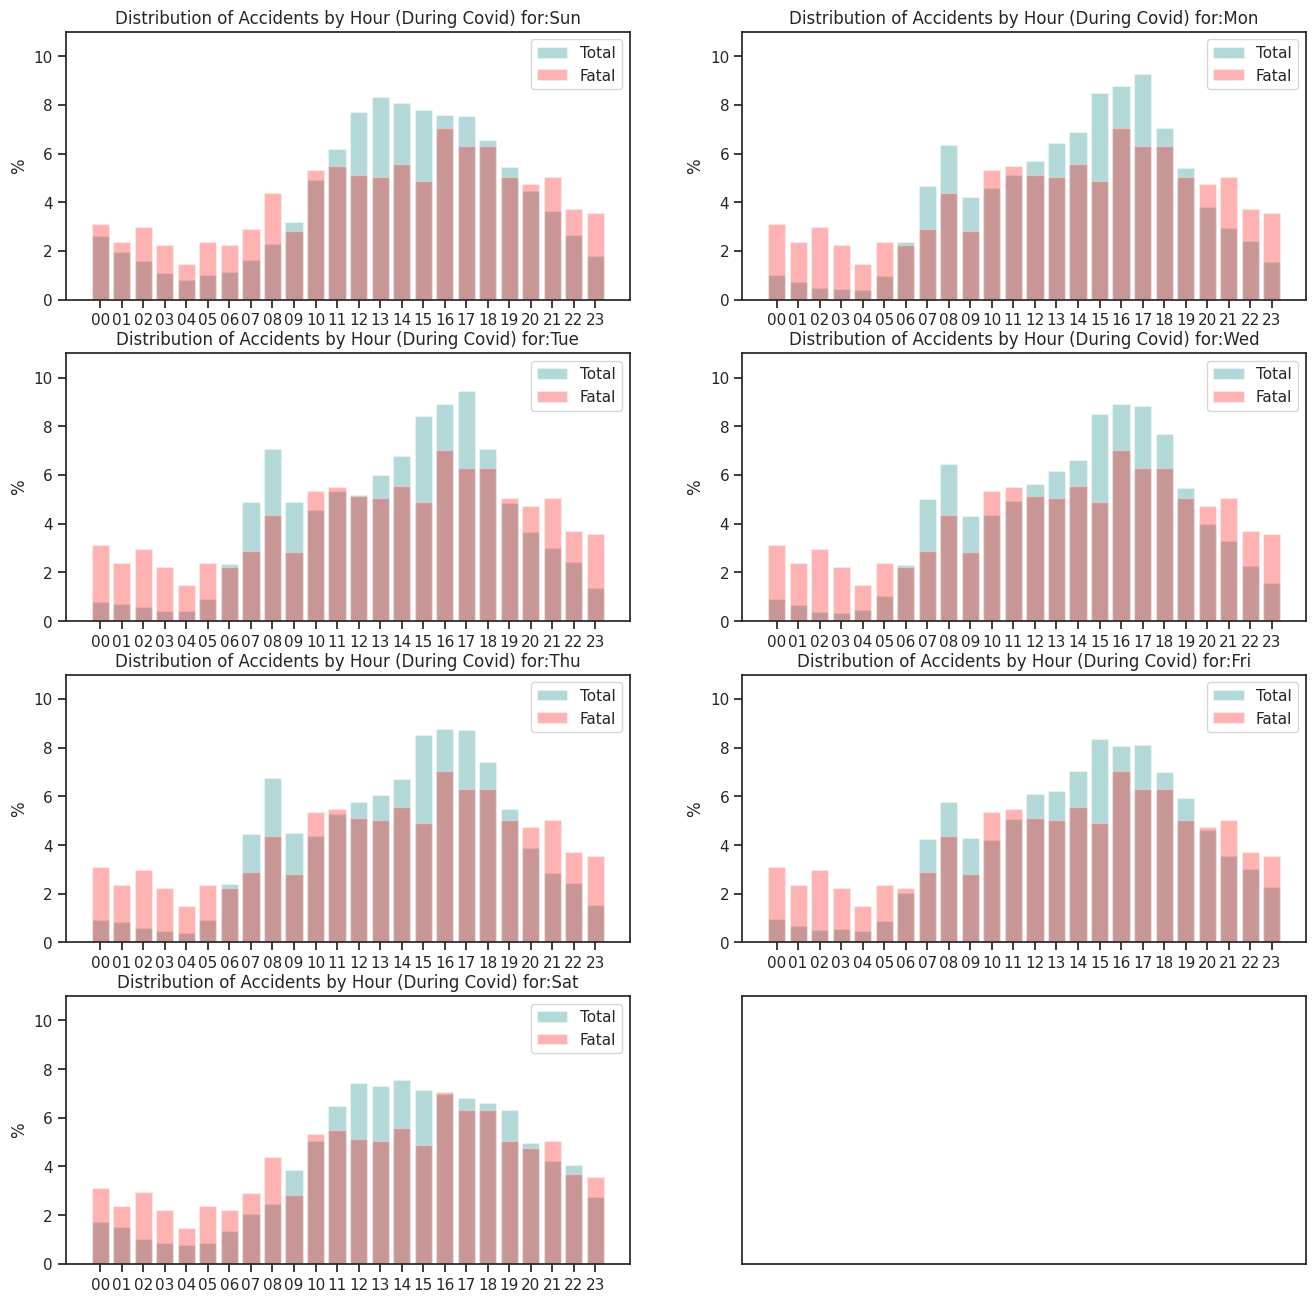

In [135]:
Day_Of_Week_Dict = {1:"Sun", 2:"Mon", 3:"Tue", 4:"Wed", 5:"Thu", 6:"Fri", 7:"Sat"}

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16,16))
count = 0

for i, col in enumerate(covid_df["day_of_week"].sort_values().unique()):
    Acc_By_Hour_By_Day = covid_df["hour"].loc[covid_df["day_of_week"]==col].value_counts().sort_index()
    Acc_By_Hour_By_Day = (Acc_By_Hour_By_Day/Acc_By_Hour_By_Day.sum())*100

    Acc_By_Hour_Fatal = covid_df["hour"].loc[(covid_df["day_of_week"]==col) & (covid_df["accident_severity"]==1)].value_counts().sort_index()
    Acc_By_Hour_Fatal = (Acc_By_Hour_Fatal/Acc_By_Hour_Fatal.sum())*100

    ax[i//2, count].bar(Acc_By_Hour_By_Day.index, Acc_By_Hour_By_Day.values, alpha=0.3, color="teal", label='Total')
    ax[i//2, count].bar(Acc_By_Hour.index, Acc_By_Hour_By_Fatal.values, alpha=0.3, color="red", label='Fatal')

    ax[i//2, count].title.set_text("Distribution of Accidents by Hour (During Covid) for:" + str(Day_Of_Week_Dict.get(col)))
    ax[i//2, count].set_ylim([0,11])
    ax[i//2, count].set_ylabel("%")
    ax[i//2, count].legend()

    count = count + 1
    if count == 2: count = 0

ax[3,1].set_yticks([])
ax[3,1].set_xticks([])
plt.show()

**Geographical Distribution and Effect of Covid**

In [83]:
colnames=['accident_year','longitude','latitude','accident_severity','number_of_casualties','weekend','covid']

testdf=timeline_df[colnames]
#testdf=testdf.round({"longitude":2, "latitude":2})   #2 and 1 maybe for rounding

testdf['lon'] = testdf['longitude'].round(1)
testdf['lat']=round(testdf.latitude,1)

testdf_covid=testdf[testdf.covid==1]
testdf_normal=testdf[testdf.covid==0]
#print(testdf_covid.number_of_casualties.sum(),testdf_normal.number_of_casualties.sum())


testdf.sample(5)

<ipython-input-83-c1ff4bdf0dfe>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-83-c1ff4bdf0dfe>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,accident_year,longitude,latitude,accident_severity,number_of_casualties,weekend,covid,lon,lat
7827658,2014,-0.427286,51.386093,3,1,0,0,-0.4,51.4
8508309,2019,-3.230876,55.849902,3,1,0,0,-3.2,55.8
8537825,2020,-2.227806,53.418605,2,1,0,0,-2.2,53.4
8670516,2021,0.187910,51.895911,2,1,0,0,0.2,51.9
7721772,2014,-0.201793,51.544924,3,2,1,0,-0.2,51.5


In [84]:
print('During covid we had {} Accidents with {} Casualties'.format(testdf[testdf.covid==1].number_of_casualties.count(),testdf[testdf.covid==1].number_of_casualties.sum()))

During covid we had 90073 Accidents with 113282 Casualties


In [85]:
tempnormal=testdf[testdf.covid==0].groupby(['lon','lat']).agg(
    local_cas = pd.NamedAgg(column='number_of_casualties', aggfunc='sum'),
    local_acc = ('number_of_casualties', 'count'),
    ).reset_index()
print('Before and after covid we had {} Accidents with {} Casualties, in {} gridpoints'.format(tempnormal.local_acc.sum(),tempnormal.local_cas.sum(),len(tempnormal)))
tempnormal[tempnormal.lon>1]

Before and after covid we had 895202 Accidents with 1177084 Casualties, in 3188 gridpoints


,lon,lat,local_cas,local_acc
3103,1.1,51.1,672,506
3104,1.1,51.2,168,113
3105,1.1,51.3,1536,1197
3106,1.1,51.4,591,470
3107,1.1,51.8,644,491
...,...,...,...,...
3183,1.7,52.4,193,138
3184,1.7,52.5,945,765
3185,1.7,52.6,1217,948
3186,1.7,52.7,154,119


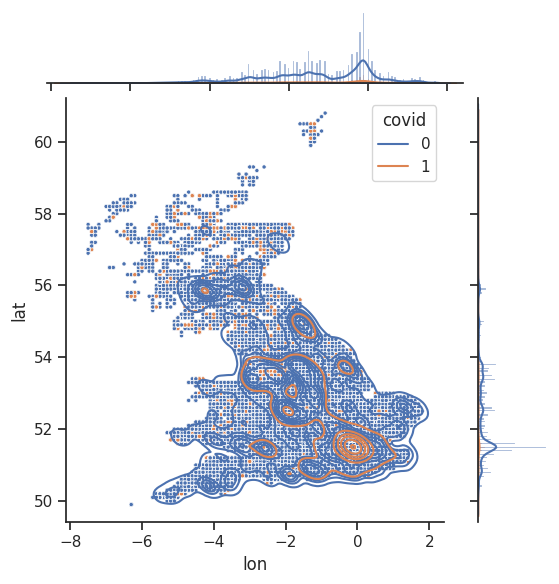

In [37]:
g = sns.jointplot(data=testdf, x="lon", y="lat",marker='.',hue='covid')
g.plot_marginals(sns.histplot, kde=True)
g.ax_joint.set_aspect('equal')# equal aspect ratio
g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=10)

Aggregating number of accidents and fatal accidents (as well as casualties just in case) on a localized grid of lon and lat

In [38]:
dfs = testdf.groupby(['lon','lat','accident_severity']).agg(
        number_of_accidents = ('number_of_casualties', 'count'),
        number_of_casualties=("number_of_casualties", 'sum'),
        ).reset_index()
dfs['local_accident_percent'] = 100 * dfs['number_of_accidents'] / dfs.groupby(['lon','lat'])['number_of_accidents'].transform('sum')
dfs['local_casualty_percent'] = 100 * dfs['number_of_casualties'] / dfs.groupby(['lon','lat'])['number_of_casualties'].transform('sum')

dfs1 = dfs.groupby(['lon','lat']).agg(
        local_accidents = ('number_of_accidents','sum'),
        local_casualties = ('number_of_casualties','sum')
).reset_index()

 #dfs1=dfs.groupby(['lon','lat'])['number_of_casualties'].agg(['sum','count']).reset_index()

#dfs2=dfs.groupby(['lon','lat'])['number_of_casualties'].transform('sum')
print(len(dfs))
dfs[dfs.lon==1.7]
#print(dfs1[dfs1.lon==1.7])
#dfs1.head()
#dfs2.iloc[-10:]
#dfs2[dfs2.lon==1.7]

8368


,lon,lat,accident_severity,number_of_accidents,number_of_casualties,local_accident_percent,local_casualty_percent
8353,1.7,52.3,2,6,9,22.222222,27.272727
8354,1.7,52.3,3,21,24,77.777778,72.727273
8355,1.7,52.4,2,28,36,17.948718,16.589862
8356,1.7,52.4,3,128,181,82.051282,83.410138
8357,1.7,52.5,1,7,10,0.823529,0.956023
8358,1.7,52.5,2,144,170,16.941176,16.252390
8359,1.7,52.5,3,699,866,82.235294,82.791587
8360,1.7,52.6,1,7,10,0.651769,0.726216
8361,1.7,52.6,2,207,279,19.273743,20.261438
8362,1.7,52.6,3,860,1088,80.074488,79.012346


In [39]:

dfs1[dfs1.lon==1.7]

,lon,lat,local_accidents,local_casualties
3194,1.7,52.3,27,33
3195,1.7,52.4,156,217
3196,1.7,52.5,850,1046
3197,1.7,52.6,1074,1377
3198,1.7,52.7,130,169


In [40]:

#FatalMerged=pd.merge(dfs1,dfs[dfs.accident_severity==1],on=['lon','lat'],how='left',validate='one_to_one')
Merged=pd.merge(dfs1,dfs,on=['lon','lat'],how='left',validate='one_to_many')
Merged[(Merged.lon==1.7) & (Merged.accident_severity==1)]
#Merged[Merged.lon==1.7]


,lon,lat,local_accidents,local_casualties,accident_severity,number_of_accidents,number_of_casualties,local_accident_percent,local_casualty_percent
8357,1.7,52.5,850,1046,1,7,10,0.823529,0.956023
8360,1.7,52.6,1074,1377,1,7,10,0.651769,0.726216
8363,1.7,52.7,130,169,1,1,1,0.769231,0.591716


We can do the same for covid and non-covid to investigate geographical effect on number of accidents and percentage of fatal accidents

In [41]:
locations = dfs1[['lat', 'lon']]
weights = dfs1['local_casualties']
# set figure layout for our future HTML file
figure_layout = {
    'width': '70%',
    'height': '100vh',
    'border': '3px solid white',
    'padding': '1px'
}
# set coordinates (the geographic center of Minsk)
coordinates = (54., -2.5)

fig = gmaps.figure(center=coordinates,
                   zoom_level=6,
                   map_type='HYBRID',
                   layout=figure_layout)

fig.add_layer(gmaps.heatmap_layer(locations,
                                  weights=weights,
                                  point_radius=10,
                                  max_intensity=1000))
fig
#from ipywidgets.embed import embed_minimal_html
#import IPython
#embed_minimal_html('export.html', views=[fig])
#IPython.display.HTML(filename="export.html")



Figure(layout=FigureLayout(border='3px solid white', height='100vh', padding='1px', width='70%'))

In [42]:
dfscovid = testdf[testdf.covid==1].groupby(['lon','lat','accident_severity']).agg(
        number_of_accidents = ('number_of_casualties', 'count'),
        number_of_casualties=("number_of_casualties", 'sum'),
        ).reset_index()
dfscovid['local_accident_percent'] = 100 * dfscovid['number_of_accidents'] / dfscovid.groupby(['lon','lat'])['number_of_accidents'].transform('sum')
dfscovid['local_casualty_percent'] = 100 * dfscovid['number_of_casualties'] / dfscovid.groupby(['lon','lat'])['number_of_casualties'].transform('sum')

dfs1covid = dfscovid.groupby(['lon','lat']).agg(
        local_accidents = ('number_of_accidents','sum'),
        local_casualties = ('number_of_casualties','sum')
).reset_index()
Mergedcovid=pd.merge(dfs1covid,dfscovid,on=['lon','lat'],how='left',validate='one_to_many')


In [43]:
locations = dfs1covid[['lat', 'lon']]
weights = dfs1covid['local_casualties']
# set figure layout for our future HTML file
figure_layout = {
    'width': '70%',
    'height': '100vh',
    'border': '3px solid white',
    'padding': '1px'
}
# set coordinates (the geographic center of Minsk)
coordinates = (54., -2.5)

fig = gmaps.figure(center=coordinates,
                   zoom_level=6,
                   map_type='HYBRID',
                   layout=figure_layout)

fig.add_layer(gmaps.heatmap_layer(locations,
                                  weights=weights,
                                  point_radius=10,
                                  max_intensity=100))

fig
#from ipywidgets.embed import embed_minimal_html
#import IPython
#embed_minimal_html('export.html', views=[fig])
#IPython.display.HTML(filename="export.html")


Figure(layout=FigureLayout(border='3px solid white', height='100vh', padding='1px', width='70%'))

In [44]:
dfsnormal = testdf[testdf.covid==0].groupby(['lon','lat','accident_severity']).agg(
        number_of_accidents = ('number_of_casualties', 'count'),
        number_of_casualties=("number_of_casualties", 'sum'),
        ).reset_index()
dfsnormal['local_accident_percent'] = 100 * dfsnormal['number_of_accidents'] / dfsnormal.groupby(['lon','lat'])['number_of_accidents'].transform('sum')
dfsnormal['local_casualty_percent'] = 100 * dfsnormal['number_of_casualties'] / dfsnormal.groupby(['lon','lat'])['number_of_casualties'].transform('sum')

dfs1normal = dfsnormal.groupby(['lon','lat']).agg(
        local_accidents = ('number_of_accidents','sum'),
        local_casualties = ('number_of_casualties','sum')
).reset_index()
Mergednormal=pd.merge(dfs1covid,dfscovid,on=['lon','lat'],how='left',validate='one_to_many')

In [45]:
dfs1normal[dfs1normal.lon==1.6]

,lon,lat,local_accidents,local_casualties
3174,1.6,52.1,4,4
3175,1.6,52.2,82,108
3176,1.6,52.3,110,176
3177,1.6,52.4,135,190
3178,1.6,52.5,220,318
3179,1.6,52.6,93,183
3180,1.6,52.7,121,179
3181,1.6,52.8,13,16


In [86]:
#dfs1covid[dfs1covid.lon==1.6]
dfscompare=pd.merge(dfs1normal,dfs1covid,on=['lon','lat'],how='left',validate='one_to_one')
dfscompare = dfscompare.fillna(0)
dfscompare['ScaledDiff']=dfscompare.local_casualties_y-dfscompare.local_casualties_x*0.1
dfscompare[dfscompare.lon==1.6]

,lon,lat,local_accidents_x,local_casualties_x,local_accidents_y,local_casualties_y,ScaledDiff
3174,1.6,52.1,4,4,0.0,0.0,-0.4
3175,1.6,52.2,82,108,13.0,13.0,2.2
3176,1.6,52.3,110,176,8.0,12.0,-5.6
3177,1.6,52.4,135,190,14.0,24.0,5.0
3178,1.6,52.5,220,318,20.0,22.0,-9.8
3179,1.6,52.6,93,183,19.0,50.0,31.7
3180,1.6,52.7,121,179,24.0,30.0,12.1
3181,1.6,52.8,13,16,0.0,0.0,-1.6


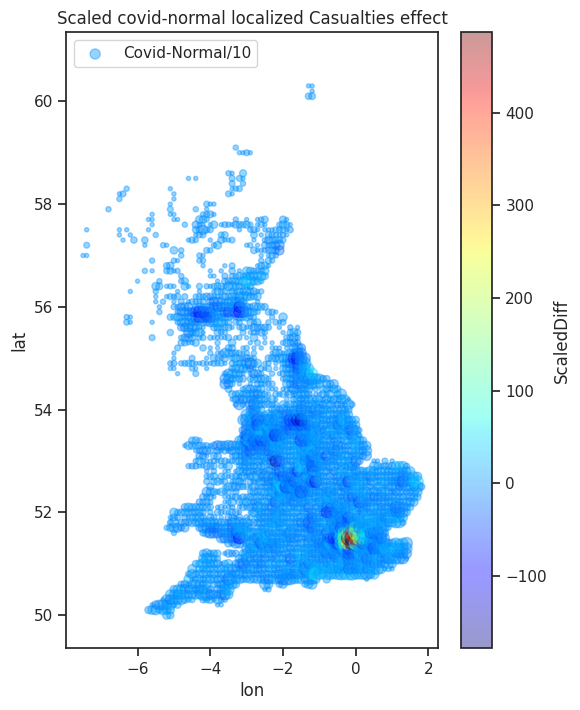

In [47]:
dfscompare.plot(kind="scatter", x="lon", y="lat",
    s=30*np.log10(dfscompare['local_casualties_y']+1), label="Covid-Normal/10",
    c="ScaledDiff", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(6,8)
)
plt.title('Scaled covid-normal localized Casualties effect')
plt.legend()
plt.show()


London has significant increase in number of casualties during covid . every other place has managed much better. Yet the overall we have increased the number of accidents and casualties by a factor of 10/7=1.43 during covid.

In [48]:
locations = dfscompare[['lat', 'lon']]
weights = dfscompare['ScaledDiff']-min(dfscompare['ScaledDiff'])

#weights. We can concat some sclaed values to certain lat o lon for refrence

# set figure layout for our future HTML file
figure_layout = {
    'width': '70%',
    'height': '100vh',
    'border': '3px solid white',
    'padding': '1px'
}
# set coordinates (the geographic center of Minsk)
coordinates = (54., -2.5)

fig = gmaps.figure(center=coordinates,
                   zoom_level=6,
                   map_type='HYBRID',
                   layout=figure_layout,
                   )

fig.add_layer(gmaps.heatmap_layer(locations,
                                  weights=weights,
                                  point_radius=10,
                                  max_intensity=False))

fig

Figure(layout=FigureLayout(border='3px solid white', height='100vh', padding='1px', width='70%'))

This doesn't work as it not accept negative weights

**Nothing Serious Down here**

In [49]:
tempcovid=testdf[testdf.covid==1].groupby(['lon','lat']).agg(
    local_cas = pd.NamedAgg(column='number_of_casualties', aggfunc='sum'),
    local_acc = ('number_of_casualties', 'count'),
    ).reset_index()
#severity_names=["Fatal", "Severe", "Minor"]
#tempcovid['severity']=tempcovid['accident_severity'].apply(lambda num: severity_names[int(num)-1])
print('During covid we had {} Accidents with {} Casualties'.format(tempcovid.local_acc.sum(),tempcovid.local_cas.sum()))
tempcovid[tempcovid.lon>1]

During covid we had 90059 Accidents with 113265 Casualties


,lon,lat,local_cas,local_acc
2494,1.1,51.1,75,60
2495,1.1,51.2,12,10
2496,1.1,51.3,182,148
2497,1.1,51.4,67,53
2498,1.1,51.8,68,52
...,...,...,...,...
2571,1.7,52.4,24,18
2572,1.7,52.5,101,85
2573,1.7,52.6,160,126
2574,1.7,52.7,15,11


ValueError: ignored

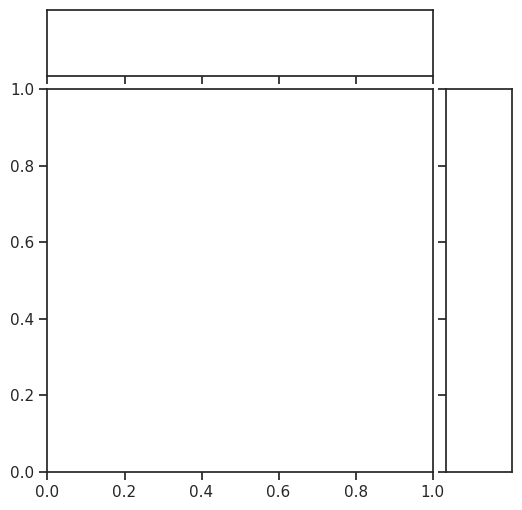

In [ ]:
g = sns.jointplot(data=tempcovid, x="lon", y="lat",marker='.',hue='accident_severity')
g.plot_marginals(sns.histplot, kde=True)
#g.ax_joint.set_aspect('equal')
g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=10)

In [ ]:
fatcov=tempcovid[tempcovid.severity=='Fatal']
fatcov

,lon,lat,accident_severity,local_cas,local_acc,severity
0,-4.5,53.3,1,1,1,Fatal
3,-3.8,53.3,1,1,1,Fatal


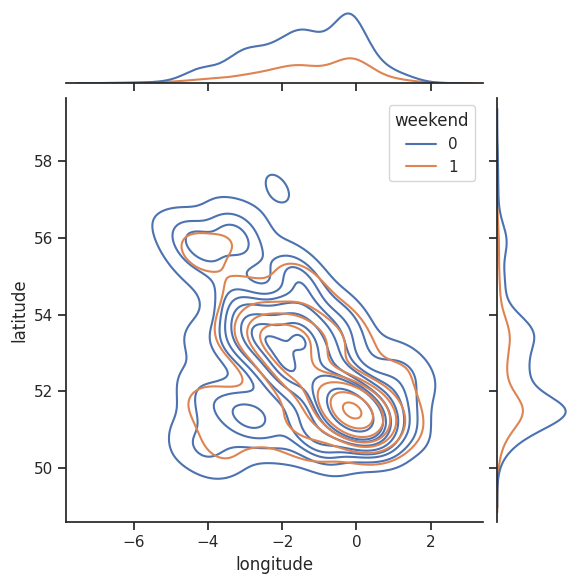

In [ ]:
sns.jointplot(
    data=testdf,
    x="longitude", y="latitude", hue="weekend",
    kind="kde"
)


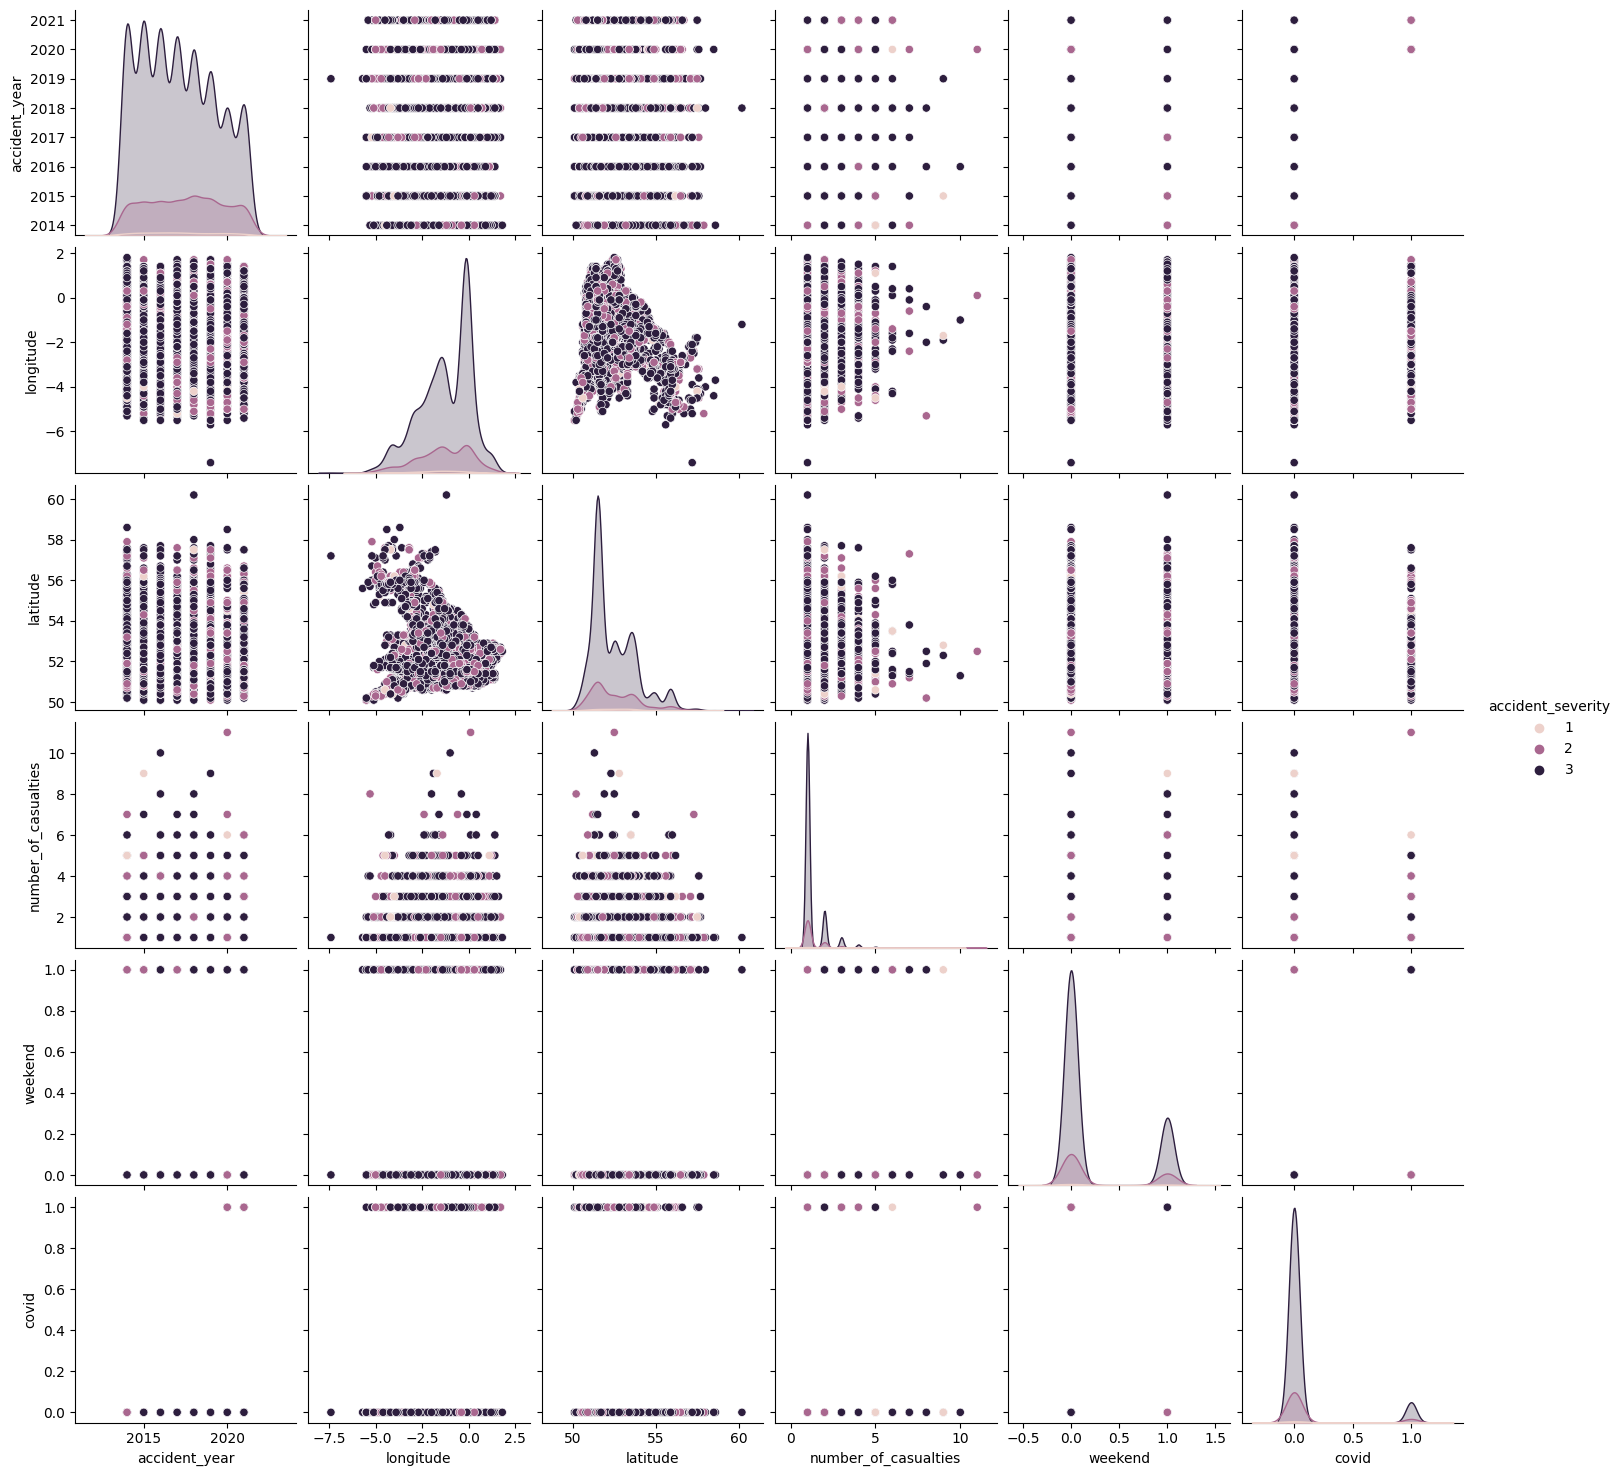

In [ ]:
sns.pairplot(data=testdf, hue="accident_severity",)
#g = sns.PairGrid(dfdf, hue="accident_severity")
#g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
#g.map_diag(sns.histplot, kde=True)


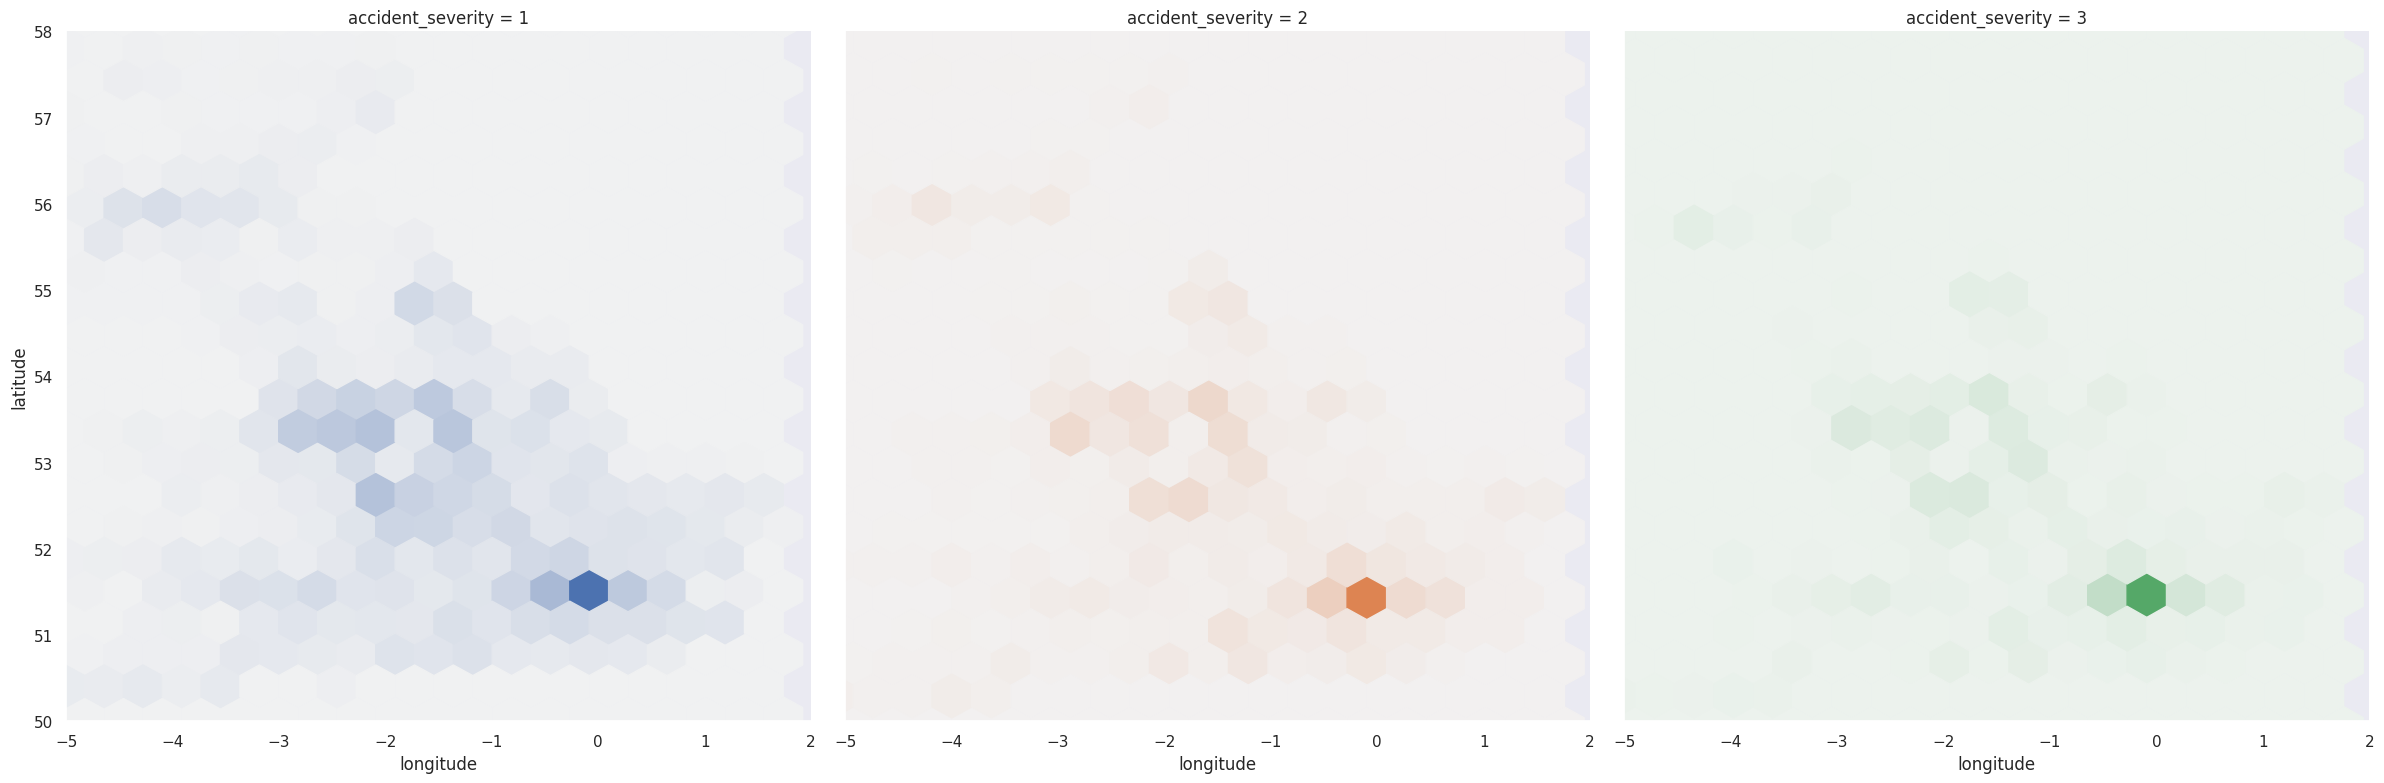

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)
    plt.xlim(-5,2)
    plt.ylim(50,58)

with sns.axes_style("dark"):
    g = sns.FacetGrid(timeline_df, hue="accident_severity", col="accident_severity", height=8)
g.map(hexbin, "longitude", "latitude")#, extent=[0, 50, 0, 10]);


In [ ]:
timeline_df.head()

In [ ]:
import plotly.express as px
fig = px.density_mapbox(testdf, lat='latitude', lon='longitude', z='number_of_casualties', radius=5,
                        center=dict(lat=52, lon=0), zoom=5,opacity=.4, width=10,height=30,
                        mapbox_style="stamen- terrain")
#fig = go.Figure(go.Densitymapbox(lat=timeline_df.latitude, lon=timeline_df.longitude, z=timeline_df.number_of_casualties,radius=10))
#fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=1, center=dict(lat=53, lon=0), zoom=9,)
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#iplot(fig)
fig